#                 NEURAL NETWORKS AND DEEP LEARNING

In [1]:
# here we import the modules we will need and connect to google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

%matplotlib inline
from matplotlib import pyplot as plt
import my_utils as mu # same as given in Labs, no changes done to my_utils.py
import torch
import torch.nn as nn
from torch.utils import data
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import torchvision
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image



Mounted at /content/gdrive


## 1. Load the dataset

* Here we using the function from the myutils.py to get two dataloader objects train_iter and test_iter

In [2]:
def get_dataloader_workers():  
    """Use 4 processes to read the data."""
    return 4

trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5), (0.5))])

mnist_train = torchvision.datasets.FashionMNIST(root="data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="data", train=False, transform=trans, download=True)

batch_size = 256
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


* Fashion-MNIST consists of images from 10 categories, each represented by 6000 images in the training dataset and by 1000 in the test dataset.<br><br>
* The training set contains 60000 images and the test set contain 10000 images, respectively.

In [ ]:
print("Number of images in the training set = ", len(mnist_train))
print("Number of images in the test set = ", len(mnist_test))

Number of images in the training set =  60000
Number of images in the test set =  10000


In [ ]:
X,y = next(iter(train_iter))
print("Dimensions of X: ",X.size())
print("Dimensions of y: ",y.size())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Dimensions of X:  torch.Size([256, 1, 28, 28])
Dimensions of y:  torch.Size([256])


* Here X is a pytorch tensor of dimension 256 x 1 x 28 x 28:
    - **256** here represents our batch size
    - **1** is the number of channels but since we are using greyscale images we would just have 1 channel
    - **28 x 28** represents shape of an image with height *h* and width *w* pixels as *h* x *w* of each input image<br><br>
    
* y is a pytorch tensor aswell and represents the true label of the image reprsented by the tensor X

## Visualise the dataset

* We will display 18 images from our training dataset

In [ ]:
A = X[:18] # A is subset of 18 out of our batch of 256 images 
b = y[:18]
A.shape

torch.Size([18, 1, 28, 28])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


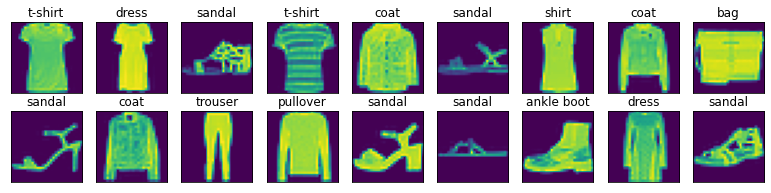

In [ ]:
# here we are showing the images and their corresponding labels of the 18 images in our training set
# we are using the function show_images predifined in myutils.py

mu.show_images(A.reshape(18, 28, 28), 2, 9, titles=mu.get_fashion_mnist_labels(b));

## Visualize the patches

* First lets obtain a random image from our dataset

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


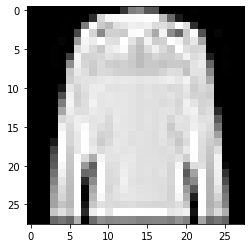

In [ ]:
image = X[1][0]
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

* Now each image is $28$ X $28$ pixels so in total there are $784$ pixels($28$ X $28$)

* Each patch has dimension $K$ X $K$, which means each patch has $K^{2}$ pixels in total, so to obtain Non-overlapping patches($N_{p}$) we should get integer value for $784$ $//$ $K^{2}$

In [ ]:
print("If we want our patch to be of dimension(i.e K x K) 7x7 then in total we will have" , 784//(7**2), "patches" )

If we want our patch to be of dimension(i.e K x K) 7x7 then in total we will have 16 patches


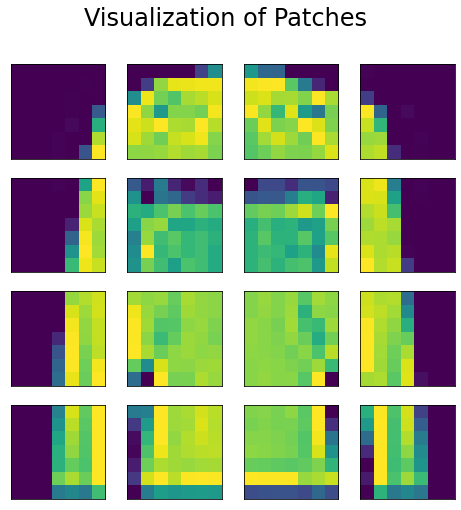

In [ ]:
patch_size = 7 # patch size here represents the dimension of our patch i.e K
number_of_patches = int((28**2)/(patch_size**2))
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of Patches", fontsize=24)
fig.add_axes()
img = np.asarray(image)
for i in range(0, number_of_patches):
    x = i % int(number_of_patches**(0.5))
    y = i // int(number_of_patches**(0.5))
    patch = img[y*patch_size:(y+1)*patch_size, x*patch_size:(x+1)*patch_size]
    ax = fig.add_subplot(int(number_of_patches**(0.5)), int(number_of_patches**(0.5)), i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

In [3]:
def get_patches(image,patch_size):
  """this function will take an image tensor as input and will output Non-overlapping patches,
  where each patch is of size that is provided as paramter value of patch_size to the function"""
  #image = torch.tensor(image)
  number_of_patches = int( (28**2) / patch_size**2)
  image = image.squeeze(dim = 1) # we are squeezing out the dimension that represents the number of channels

  # Now the dimension of the image if batch_size x 28 x 28 so we are unfolding on dimension 1 and 2
  # Now the patch size is batch_size x sqrt(number_of_patches) x sqrt(number_of_patches) x patch_size x patch_size
  patches = image.unfold(1,patch_size,patch_size).unfold(2,patch_size,patch_size)

  # to obtain the shape of patches as batch_size x number_of_patches x patch_size x patch_size, we reshape
  patches = patches.reshape([-1,number_of_patches,patch_size,patch_size])

  # Here we vectorize our patches
  patches_vectorized = patches.reshape([-1,number_of_patches, patch_size**2])

  return patches_vectorized

* Below in the function get_patches, we are passing our batch of images X, where each image is of 28x28, and we are also passing the patch height and widhth we want i.e K as per our model

* Since we are passing 7 as our patch dimension we would get 16 non-overlapping patches in total where each patch is of dimension 7x7

In [ ]:
(get_patches(X,7)).shape

torch.Size([256, 16, 49])

## 2. Model (Stem, Backbone and Classifier)

We have created a class called model whose contructors takes `patch_size`,`number_of_patches`,`hidden_units_stem`,`hidden_units_1`,`hidden_units_2`,`hidden_units_3`,`hidden_units_4`,`hidden_units_5`,`number_of_classes` as arguments. These arguments are being explained below:

i) <b> Stem</b> <br>
* Stem block takes as input an image <b>I</b> of size $28$ x $28$ and then we pass it through the function `get_patches` where we divide the image into non-overlapping patches($N_{p}$) and each patches is of dimension `patch_size` x `patch_size` i.e $K$ x $K$ as per our model. Also note that `patch_size` is our argument in our constructor.

* Suppose we want each patch to be of dimension 7x7 so the function `get_patches` will output $x$ of shape `batch_size` x $16$ x $49$. We will then pass this output to the linear layer called `stem_linear_layer` which will have `in_feature` value of $patch_size^{2}$ (in our case 49) and `out_feature` value of 128(`hidden_units_stem` in our constructor). The `stem_linear_layer` will output $x$ whose shape would be `batch_size` x `number_of_patches` x `hidden_units_stem`. This output represents `X` in our model

ii) <b> Backbone </b> <br>
Our backbone consists of 3 blocks and each block contains 2 MLPs and each MLP contains 2 linear layers. `Block 1` has in total 4 linear layers. 

Assume that we want our patch dimension i.e $K$ x $K$ to be $7$ x $7$ and so we will have in total 16 patches of an image and also   suppose that we take following values for hidden units for our linear layers.<br>

> hidden_units_stem = 128 <br>
> hidden_units_1 = 150 <br>
> hidden_units_2 = 200 <br>
> hidden_units_3 = 250 <br>
> hidden_units_4 = 300 <br>
> hidden_units_5 = 100 <br>
> number_of_classes = 10 <br>

* After getting the output from the `stem_linear_layer` we pass it to `B1_linear_layer`. But before passing it to the linear layer we transpose it as it is required by the given model and so after the transpose the shape of the input is now `batch_size` x `hidden_units_stem` x `number_of_patches`(256 x 128 x 16). The `B1_linear_layer` will take `number_of_patches`(16) as `in_feature` value since as per our model we transposed `X` and will have 128(`hidden_units_stem`) as `out_feature`. The output of this linear layer will have shape `batch_size` x `hidden_units_stem` x `hidden_units_1`(256 x 128 x150).Then we perform Batch Normalization and apply the activation function `ReLU` on this output. Then we will pass the output of the B1_linear _layer to another linear layer called `B1_linear_layer_2`. <br><br>

* The `B1_linear_layer_2` will have `hidden_units_1`(150) as `in_feature` and `hidden_units_2`(200) as `out_feature` giving us $x$ whose shape would be `batch_size` x `hidden_stem_units` x `hidden_units_2`(256 x 128 x 200). The output of this second linear layer `B1_linear_layer_2` is `O1` as shown in our model. The shape of `O1` is `batch_size` x `hidden_units_stem` x `hidden_units_2`(256 x 128 x 200) <br><br>

* Now we will transpose this `O1` before passing it into our third linear layer called `B1_linear_layer_3`, which will take `hidden_stem_units` as `in_feature` since the shape of `O1` **after being transposed** is `batch_size` x`hidden_units_2` x `hidden_units_stem`(256 x 200 x 128) and `hidden_units_1`(150) as `out_feature` value. So the shape of the output $x$ from the `B1_linear_layer_3` is `batch_size` x `hidden_units_2` x `hidden_units_1`(256 x 200 x 150). Then again we perform Batch Normalization and apply the activation function on this output from `B1_linear_layer_3`.<br><br>

* We will then pass this output to our fourth linear layer called `B1_linear_layer_4` which will take `hidden_units_1`(150) as `in_feature` value and `hidden_units_2`(200) as `out_feature` value. This layer will output $x$ whose shape would be `batch_size` x `hidden_units_2` x `hidden_units_2`(256 x 200 x 200) <br><br>

* Now the output of the `B1_linear_layer_4` becomes the input of first linear layer of the second block. Here again as per model we transpose but since my model architecture is defined in such a way that the dimension 1 and 2 of the output is same, so there is infact no need to transpose and we can directly pass this output into our first layer of the second block.<br><br>

* We will then again perform the same steps described above and making sure each time that `in_feature` value of the linear layer matches the dimension 2 of the input to that layer and transposing the output of the second layer of the block before passing the output to the third layer of that block.

iii) <b> Classifier </b> <br>
* The way I have defined my linear layers in the final block 3, I have made sure that output `O2` will have shape of $N_{p}$ x $d_{0}$, where $d_{0}$ is `hidden_units_5`. Then we will compute mean feature $x$ along the columns of the output `O2`. Finally, we will feed this feature linear layer called `classifier` which will have `in_feature` value of `hidden_units_5`(100) and `out_feature` value of `number_of_classes`(10). Note that since we are using CrossEntropyLoss criterion to compute loss we have not applied softmax to the output of the `classifier` linear layer since `nn.CrossEntropyLoss` applies softmax anyway to output of the classifier.



In [4]:
class model(torch.nn.Module):
    def __init__(self,patch_size,number_of_patches,hidden_units_stem,hidden_units_1,hidden_units_2,hidden_units_3,hidden_units_4,hidden_units_5,number_of_classes):
      super(model, self).__init__() 

      self.patch_size = patch_size
      self.number_of_patches = number_of_patches
      self.relu = nn.ReLU()      
      self.act_fn = nn.GELU()



      #################    STEM     ############################## 
      self.stem_linear_layer = nn.Linear(patch_size**2, hidden_units_stem)
      self.batchnorm_stem = nn.BatchNorm1d(number_of_patches)

      ###############   BACKBONE  #########################

      ##### BLOCK 1 ########
      self.B1_linear_layer_1 = nn.Linear(number_of_patches,hidden_units_1)
      self.B1_linear_layer_2 = nn.Linear(hidden_units_1,hidden_units_2)
      self.B1_linear_layer_3 = nn.Linear(hidden_units_stem,hidden_units_1)
      self.B1_linear_layer_4 = nn.Linear(hidden_units_1,hidden_units_2)
      self.B1_batchnorm_1 = nn.BatchNorm1d(hidden_units_stem)
      self.B1_batchnorm_2 = nn.BatchNorm1d(hidden_units_2)
      
      ####### BLOCK 2  ##########
      self.B2_linear_layer_1 = nn.Linear(hidden_units_2,hidden_units_3)
      self.B2_linear_layer_2 = nn.Linear(hidden_units_3,hidden_units_4)
      self.B2_linear_layer_3 = nn.Linear(hidden_units_2,hidden_units_3)
      self.B2_linear_layer_4 = nn.Linear(hidden_units_3,hidden_units_4)
      self.B2_batchnorm_1 = nn.BatchNorm1d(hidden_units_2)
      self.B2_batchnorm_2 = nn.BatchNorm1d(hidden_units_4)
      
      ########## BLOCK 3 ############
      self.B3_linear_layer_1 = nn.Linear(hidden_units_4,hidden_units_3)
      self.B3_linear_layer_2 = nn.Linear(hidden_units_3,number_of_patches)
      self.B3_linear_layer_3 = nn.Linear(hidden_units_4,hidden_units_2)
      self.B3_linear_layer_4 = nn.Linear(hidden_units_2,hidden_units_5)
      self.B3_batchnorm_1 = nn.BatchNorm1d(hidden_units_4)
      self.B3_batchnorm_2 = nn.BatchNorm1d(number_of_patches)
      
      

      ############## CLASSIFIER #############
      self.classifier = nn.Linear(hidden_units_5, number_of_classes)

    # Assume that we want 16 patches, each of dimension 7 x 7 and with following hidden units for linear layers
    #hidden_units_stem = 128, hidden_units_1 = 150,hidden_units_2 = 200, hidden_units_3 = 250,hidden_units_4 = 300,
    #hidden_units_5 = 100 ,number_of_classes = 10
    
    def forward(self,x):
      # dimension of x is batch_size x 28 x 28
      # after applying the function get_patches dimension of x is now batch_size x number_of_patches_ x (patches_size**2)
      x = get_patches(x,self.patch_size) # the shape of x after applying the function get_patches is 256 x 16 x 49
      #print("patches dim:" , x.shape)

      # dimension of x is now batch_size x number_of_patches_ x stem_linear_layer(d in our model)
      x = self.stem_linear_layer(x) # the shape of x after passing through stem_linear_layer will be 256 x 16 x 128
      #print("stem_layer:" ,x.shape)

      # we transpose our X here 
      x = torch.transpose(x,1,2) # the shape of x after transpose will be 256 x 128 x 16
      #print("transpose before 1st block", x.shape)

      #### BLOCK 1 ########
      x = self.B1_linear_layer_1(x) # the shape of x **after passing** through this layer will be 256 x 128 x 150
      x = self.B1_batchnorm_1(x) # perform batch normalization
      x = self.relu(x) # apply activation function ReLU
      #x = self.act_fn(x)
      x = self.B1_linear_layer_2(x) #the shape of x **after passing** through this layer will be 256 x 128 x 200
      #print("block1_1: ",x.shape)

      # x is O1 which we transpose here to O1^T as per our model
      x = torch.transpose(x,1,2) # the shape of x **after being transposed **  will be 256 x 200 x 128
      #print("O1 transpose: ",x.shape)

      x = self.B1_linear_layer_3(x) #the shape of x **after passing** through this layer will be 256 x 200 x 150
      x = self.B1_batchnorm_2(x)
      x = self.relu(x)
      #x = self.act_fn(x)
      x = self.B1_linear_layer_4(x) #the shape of x **after passing** through this layer will be 256 x 200 x 200
      #print("block1_4: ",x.shape)
      
      #### BLOCK 2 ########
      # since the output from the last linear layer of block 1 has same dimension 1 and 2 , there is no need to transpose here
      x = self.B2_linear_layer_1(x) #the shape of x **after passing** through this layer will be 256 x 200 x 250
      x = self.B2_batchnorm_1(x)
      x = self.relu(x)
      #x = self.act_fn(x)
      x = self.B2_linear_layer_2(x) #the shape of x **after passing** through this layer will be 256 x 200 x 300
      x = torch.transpose(x,1,2)
      x = self.B2_linear_layer_3(x) #the shape of x **after passing** through this layer will be 256 x 300 x 250
      x = self.B2_batchnorm_2(x)
      x = self.relu(x)
      #x = self.act_fn(x)
      x = self.B2_linear_layer_4(x) # the shape of x **after passing** through this layer will be 256 x 300 x 300

      #### BLOCK 3 ########
      # since the output from the last linear layer of block 1 has same dimension 1 and 2 , there is no need to transpose here
      x = self.B3_linear_layer_1(x) # the shape of x **after passing** through this layer will be 256 x 300 x 250
      x = self.B3_batchnorm_1(x)
      x = self.relu(x)
      #x = self.act_fn(x)
      x = self.B3_linear_layer_2(x) # the shape of x **after passing** through this layer will be 256 x 300 x 16

      x = torch.transpose(x,1,2) # the shape of x **after being transposed **  will be 256 x 16 x 300

      x = self.B3_linear_layer_3(x) # the shape of x **after passing** through this layer will be 256 x 16 x 200
      x = self.B3_batchnorm_2(x)
      x = self.relu(x)
      #x = self.act_fn(x)
      out = self.B3_linear_layer_4(x) # the shape of out **after passing** through this layer will be 256 x 16 x 100
      #print("before mean: ",out.shape)

      out = torch.mean(out,1) # the shape of out **after passing** through this layer will be 256 x 100
      #print("after mean: ",out.shape)
      out  = self.classifier(out) # the shape of out **after passing** through this layer will be 256 x 10

      #print("out: ", out.shape)

      return out


## 3. Parameter Initialization

In [6]:
def init_weights(m):
    if type(m) == nn.Linear:     # by checking the type we can init different layers in different ways
       #torch.nn.init.xavier_uniform_(m.weight)  
       torch.nn.init.kaiming_normal_(m.weight)        


In [6]:
patch_size,number_of_patches,hidden_units_stem,hidden_units_1,hidden_units_2,hidden_units_3,hidden_units_4,hidden_units_5,number_of_classes = 7,16,128,150,200,250,300,100,10
net = model(patch_size,number_of_patches,hidden_units_stem,hidden_units_1,hidden_units_2,hidden_units_3,hidden_units_4,hidden_units_5,number_of_classes)
net.apply(init_weights)
print(net)

model(
  (relu): ReLU()
  (act_fn): GELU()
  (stem_linear_layer): Linear(in_features=49, out_features=128, bias=True)
  (batchnorm_stem): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (B1_linear_layer_1): Linear(in_features=16, out_features=150, bias=True)
  (B1_linear_layer_2): Linear(in_features=150, out_features=200, bias=True)
  (B1_linear_layer_3): Linear(in_features=128, out_features=150, bias=True)
  (B1_linear_layer_4): Linear(in_features=150, out_features=200, bias=True)
  (B1_batchnorm_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (B1_batchnorm_2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (B2_linear_layer_1): Linear(in_features=200, out_features=250, bias=True)
  (B2_linear_layer_2): Linear(in_features=250, out_features=300, bias=True)
  (B2_linear_layer_3): Linear(in_features=200, out_features=250, bias=True)
  (B2_linear_layer_4): Linear(in_features=250, ou

## 4. Testing the model

In [7]:
train_iter2 = iter(train_iter)
z,k= next(train_iter2)
net = model(7,16,128,150,200,250,300,100,10)
#print(net)
y_hat = net(z)
print(y_hat.shape)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 10])


In [ ]:
# Training our model on Fashion Mnist

wd,lr, num_epochs, batch_size = 0, 0.001, 30, 256
#train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers())
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = wd)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Training Functions

* Here are all the functions that were used to train and evaluate the model

In [7]:
def train(net, train_iter, test_iter, loss, num_epochs, optimizer, device):
    """Train and evaluate a model with CPU or GPU."""
    net.to(device)
    animator = mu.d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = mu.d2l.Timer()
    for epoch in range(num_epochs):
        metric = mu.d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], mu.d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                              (train_loss, train_acc, None))
        test_acc = mu.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [8]:
def train_scheduler(net, train_iter, test_iter, loss, num_epochs, optimizer, device):
    """Train and evaluate a model with CPU or GPU."""
    net.to(device)
    animator = mu.d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = mu.d2l.Timer()
    for epoch in range(num_epochs):
        metric = mu.d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], mu.d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                              (train_loss, train_acc, None))
        test_acc = mu.evaluate_accuracy_gpu(net, test_iter)
        print(f'The test accuracy for epoch {epoch+1} is {test_acc*100}')
        # Using Pytorch In-built scheduler
        scheduler.step(test_acc)
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

## 5. Hyperparameters tuning

#### i) First we will train on 3 epochs with different optimizers Adam, SGD and RMS-Prop and will observe with which optimizer we get highest test accuracy and lowest train loss.

####  Adam

loss 0.320, train acc 0.882, test acc 0.873
1292.6 examples/sec on cuda


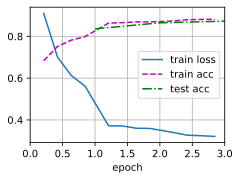

In [9]:
# Training our model on Fashion Mnist

wd,lr, num_epochs, batch_size = 0, 0.001, 3, 256
#train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers())
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = wd)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
train(net, train_iter, test_iter, loss, num_epochs, optimizer, device)

####  SGD

loss 1.740, train acc 0.468, test acc 0.485
1287.2 examples/sec on cuda


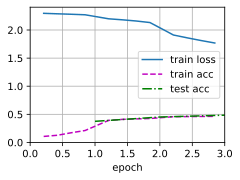

In [10]:
# Training our model on Fashion Mnist

wd,lr, num_epochs, batch_size = 0, 0.001, 3, 256
#train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers())
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay = wd)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
train(net, train_iter, test_iter, loss, num_epochs, optimizer, device)

####  RMS-Prop

loss 0.385, train acc 0.858, test acc 0.815
1289.2 examples/sec on cuda


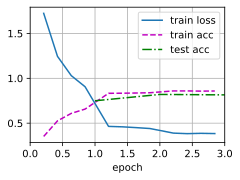

In [11]:
# Training our model on Fashion Mnist

wd,lr, num_epochs, batch_size = 0, 0.001, 3, 256
#train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers())
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(net.parameters(), lr=lr, weight_decay = wd)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
train(net, train_iter, test_iter, loss, num_epochs, optimizer, device)

* We can see that we obtained the highest accuracy with Adam.

* With only using 3 epochs Adam clearly outperforms SGD and RMS-Prop

* Hence,we will use Adam as our optimizer since Adam realizes the benefits of both AdaGrad and RMSProp.

#### ii) Now we will see which learning rate give us the highest test accuracy. we will try learning rate of 0.01 and 0.001 with Adam optimizer and by running on 5 epochs.

loss 0.343, train acc 0.875, test acc 0.857
1286.4 examples/sec on cuda


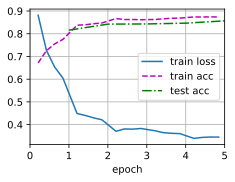

In [12]:
# Training our model on Fashion Mnist

wd,lr, num_epochs, batch_size = 0, 0.01, 5, 256
#train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers())
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = wd)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
train(net, train_iter, test_iter, loss, num_epochs, optimizer, device)

##### Now training with learning rate of 0.001

loss 0.237, train acc 0.910, test acc 0.880
1305.0 examples/sec on cuda


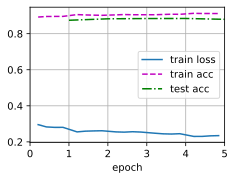

In [13]:
# Training our model on Fashion Mnist

wd,lr, num_epochs, batch_size = 0, 0.001, 5, 256
#train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers())
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = wd)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
train(net, train_iter, test_iter, loss, num_epochs, optimizer, device)

* We can clearly see that with learning rate = 0.001 we get the higher test accuracy

# 3rd BEST MODEL Training and evaluating the model with weight decay = 0, learning_rate = 0.001 and number of epochs = 30

loss 0.055, train acc 0.979, test acc 0.887
1407.1 examples/sec on cuda


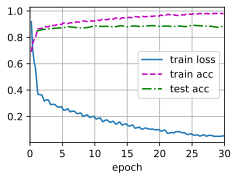

In [ ]:
# Training our model on Fashion Mnist

wd,lr, num_epochs, batch_size = 0, 0.001, 30, 256
#train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers())
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = wd)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
train(net, train_iter, test_iter, loss, num_epochs, optimizer, device)

# 2nd BEST MODEL Training and evaluating the model with weight decay = 0, learning_rate = 0.001,number of epochs = 50 and using ReduceLROnPlateau scheduler

loss 0.096, train acc 0.967, test acc 0.895
1396.8 examples/sec on cuda


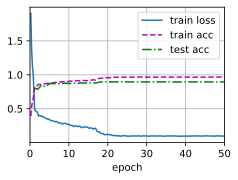

In [ ]:
wd,lr, num_epochs, batch_size = 0, 0.01, 50, 256
#train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers())
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = wd)

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1, verbose=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
train_scheduler(net, train_iter, test_iter, loss, num_epochs, optimizer, device)

In [14]:
####################    OTHER EXPERIMENTS         ##############

## Training and evaluating the model with weight decay = 0.001, learning_rate = 0.001 and number of epochs = 30

loss 0.057, train acc 0.981, test acc 0.871
2681.8 examples/sec on cuda


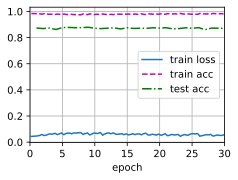

In [ ]:
# Training our model on Fashion Mnist with hyperparameters

wd,lr, num_epochs, batch_size = 0.001, 0.001, 30, 256
#train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers())
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = wd)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
train(net, train_iter, test_iter, loss, num_epochs, optimizer, device)


In [ ]:
#####################################################

## Training and evaluating the model with weight decay = 0.1, learning_rate = 0.001 and number of epochs = 30

loss 0.853, train acc 0.779, test acc 0.778
2658.4 examples/sec on cuda


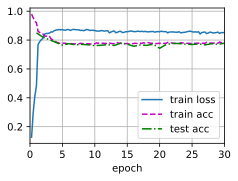

In [ ]:
# Training our model on Fashion Mnist with hyperparameters

wd,lr, num_epochs, batch_size = 0.1, 0.001, 30, 300
#train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers())
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = wd)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
train(net, train_iter, test_iter, loss, num_epochs, optimizer, device)


In [ ]:
################################

loss 0.249, train acc 0.920, test acc 0.875
2730.8 examples/sec on cuda


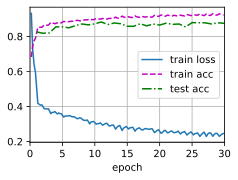

In [ ]:
# Training our model on Fashion Mnist with hyperparameters
# ReLU Kaiming 
wd,lr, num_epochs, batch_size = 0.01, 0.001, 30, 256
#train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers())
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = wd)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
train(net, train_iter, test_iter, loss, num_epochs, optimizer, device)


## Training the model by the resizing the input image from 28 x 28 to 256 x 256

loss 0.290, train acc 0.900, test acc 0.867
2099.1 examples/sec on cuda


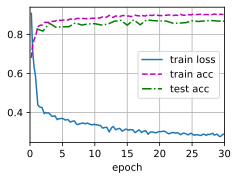

In [ ]:
def get_dataloader_workers():  
    """Use 4 processes to read the data."""
    return 4

trans1 = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5), (0.5)), transforms.Resize(256)])

mnist_train = torchvision.datasets.FashionMNIST(root="data", train=True, transform=trans1, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="data", train=False, transform=trans1, download=True)

batch_size = 256
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers())

patch_size,number_of_patches,hidden_units_stem,hidden_units_1,hidden_units_2,hidden_units_3,hidden_units_4,hidden_units_5,number_of_classes = 32,64,128,150,200,250,300,100,10
net = model(patch_size,number_of_patches,hidden_units_stem,hidden_units_1,hidden_units_2,hidden_units_3,hidden_units_4,hidden_units_5,number_of_classes)
net.apply(init_weights)

wd,lr, num_epochs, batch_size = 0.01, 0.001, 30, 256
#train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers())
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = wd)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
train(net, train_iter, test_iter, loss, num_epochs, optimizer, device)

## Training and evaluating the model with weight decay = 0.0001, learning_rate = 0.001 and number of epochs = 30

loss 0.048, train acc 0.983, test acc 0.877
789.3 examples/sec on cuda


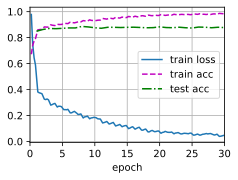

In [ ]:
# Training our model on Fashion Mnist with hyperparameters

wd,lr, num_epochs, batch_size = 0.0001, 0.001, 30, 256
#train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers())
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = wd)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
train(net, train_iter, test_iter, loss, num_epochs, optimizer, device)


## Training the model by augmenting the images. 

* The input image is randomly flipped horizontally and vertically with the probability of 0.5

loss 0.369, train acc 0.868, test acc 0.844
1298.5 examples/sec on cuda


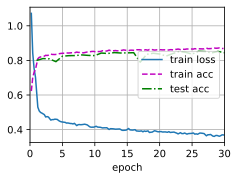

In [10]:
def get_dataloader_workers():  
    """Use 4 processes to read the data."""
    return 4

trans1 = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5), (0.5)), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5)])

mnist_train = torchvision.datasets.FashionMNIST(root="data", train=True, transform=trans1, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="data", train=False, transform=trans1, download=True)

batch_size = 256
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers())

patch_size,number_of_patches,hidden_units_stem,hidden_units_1,hidden_units_2,hidden_units_3,hidden_units_4,hidden_units_5,number_of_classes = 7,16,128,150,200,250,300,100,10
net = model(patch_size,number_of_patches,hidden_units_stem,hidden_units_1,hidden_units_2,hidden_units_3,hidden_units_4,hidden_units_5,number_of_classes)
net.apply(init_weights)

wd,lr, num_epochs, batch_size = 0.01, 0.001, 30, 256
#train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers())
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = wd)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
train(net, train_iter, test_iter, loss, num_epochs, optimizer, device)

## Training the model using the CosineScheduler

In [ ]:
# Following clas
class CosineScheduler:
  def __init__(self, max_update, base_lr=0.01, final_lr=0,warmup_steps=0, warmup_begin_lr=0):
    self.base_lr_orig = base_lr
    self.max_update = max_update
    self.final_lr = final_lrranspose 
    self.warmup_begin_lr = warmup_begin_lr
    self.max_steps = self.max_update - self.warmup_steps

  def get_warmup_lr(self, epoch):
    increase = (self.base_lr_orig - self.warmup_begin_lr) \
* float(epoch) / float(self.warmup_steps)
    return self.warmup_begin_lr + increase

  def __call__(self, epoch):
    if epoch < self.warmup_steps:
      return self.get_warmup_lr(epoch)

    if epoch <= self.max_update:
      self.base_lr = self.final_lr + (self.base_lr_orig - self.final_lr) * (1 + math.cos(math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
    
    return self.base_lr

In [7]:
from torch.optim import lr_scheduler
def train_ch6(net, train_iter, test_iter,loss, num_epochs,optimizer,
              device=mu.try_gpu(),scheduler=None):
    """Train and evaluate a model with CPU or GPU."""
    
    print('training on', device)
    net.to(device)
    animator = mu.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = mu.Timer()
    for epoch in range(num_epochs):
        metric = mu.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], mu.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                             (train_loss, train_acc, None))
        test_acc = mu.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
        if scheduler:
          if scheduler.__module__ == lr_scheduler.__name__:
            # Using PyTorch In-Built scheduler
            scheduler.step()
          else:
            # Using custom defined scheduler
            for param_group in optimizer.param_groups:
              param_group['lr'] = scheduler(epoch)

    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')


In [ ]:
scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)

In [ ]:
import math

loss 0.289, train acc 0.895, test acc 0.873
1094.3 examples/sec on cuda


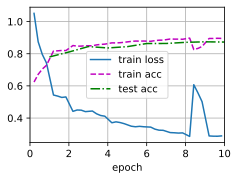

In [ ]:
# Training our model on Fashion Mnist with hyperparameters

wd,lr, num_epochs, batch_size = 0, 0.1, 10, 256
scheduler = CosineScheduler(max_update=20, base_lr=0.1, final_lr=0.001)
#train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers())
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = wd)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
train_ch6(net, train_iter, test_iter, loss, num_epochs, optimizer, device,scheduler)


In [ ]:
#########################

## Training the model using ReduceLROnPlateau scheduler

* ReduceOnPlateau reduces learning rate when a metric has stopped improving.  This scheduler reads a metrics quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced.

In [8]:
def train_scheduler(net, train_iter, test_iter, loss, num_epochs, optimizer, device):
    """Train and evaluate a model with CPU or GPU."""
    net.to(device)
    animator = mu.d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = mu.d2l.Timer()
    for epoch in range(num_epochs):
        metric = mu.d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], mu.d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                              (train_loss, train_acc, None))
        test_acc = mu.evaluate_accuracy_gpu(net, test_iter)
        print(f'The test accuracy for epoch {epoch+1} is {test_acc*100}')
        # Using Pytorch In-built scheduler
        scheduler.step(test_acc)
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

# BEST MODEL

loss 0.033, train acc 0.989, test acc 0.899
1405.4 examples/sec on cuda


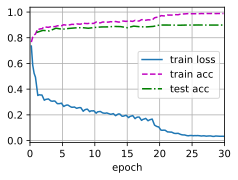

In [ ]:
# Training our model on Fashion Mnist

wd,lr, num_epochs, batch_size = 0, 0.01, 30, 256
#train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers())
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = wd)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1, verbose=True)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
train_scheduler(net, train_iter, test_iter, loss, num_epochs, optimizer, device)

In [9]:
##########    EXPERIMENTS    #############

### Training with ReduceLROnPlateau with lr = 0.001 with patch size equal to 2, patience = 1, factor = 0.1 and threshold = 1e-6

loss 0.077, train acc 0.975, test acc 0.888
984.1 examples/sec on cuda


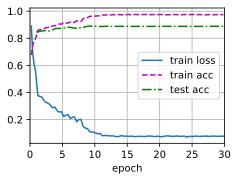

In [8]:
# Training our model on Fashion Mnist
patch_size,number_of_patches,hidden_units_stem,hidden_units_1,hidden_units_2,hidden_units_3,hidden_units_4,hidden_units_5,number_of_classes = 2,196,128,150,200,250,300,100,10
net = model(patch_size,number_of_patches,hidden_units_stem,hidden_units_1,hidden_units_2,hidden_units_3,hidden_units_4,hidden_units_5,number_of_classes)
net.apply(init_weights)
wd,lr, num_epochs, batch_size = 0, 0.001, 30, 256
#train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers())
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = wd)

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1, verbose=True, threshold = 1e-6)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
train_scheduler(net, train_iter, test_iter, loss, num_epochs, optimizer, device)

### Training with ReduceLROnPlateau with lr = 0.001 with patch size equal to 2, patience = 1, factor = 0.1, threshold = 1e-6 and GELU activation function

loss 0.065, train acc 0.979, test acc 0.889
969.8 examples/sec on cuda


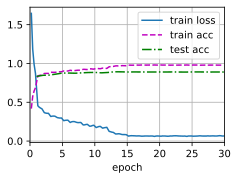

In [9]:
# Training our model on Fashion Mnist
patch_size,number_of_patches,hidden_units_stem,hidden_units_1,hidden_units_2,hidden_units_3,hidden_units_4,hidden_units_5,number_of_classes = 2,196,128,150,200,250,300,100,10
net = model(patch_size,number_of_patches,hidden_units_stem,hidden_units_1,hidden_units_2,hidden_units_3,hidden_units_4,hidden_units_5,number_of_classes)
net.apply(init_weights)
wd,lr, num_epochs, batch_size = 0, 0.01, 30, 256
#train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers())
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = wd)

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1, verbose=True, threshold = 1e-6)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
train_scheduler(net, train_iter, test_iter, loss, num_epochs, optimizer, device)

## Training model with ReduceLROnPlateau with lr = 0.0001 , factor = 0.01, patience = 1 and threshold = 1e-6

## Training model with ReduceLROnPlateau with lr = 0.0001 , factor = 0.01, patience = 1 and threshold = 1e-6 and with SGD as optimizer

loss 0.098, train acc 0.971, test acc 0.876
1445.6 examples/sec on cuda


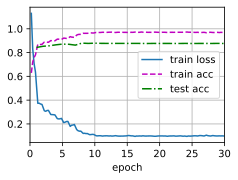

In [ ]:
# Training our model on Fashion Mnist

wd,lr, num_epochs, batch_size = 0, 0.01, 30, 256
#train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers())
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, nesterov=True)


scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1, verbose=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
train_scheduler(net, train_iter, test_iter, loss, num_epochs, optimizer, device)


* After experimenting with different hyperparameters, optimizers and schedulers we obtained our best model with following hyperparameters:

> Weight decay = 0 <br>
> Learning rate = 0.001 <br>
> Activation Function = ReLU <br>
> Optimizer = Adam <br>
> Loss = Cross Entropy <br>
> number of epochs = 30 <br>
> batch size = 256 <br>
> patience = 0 <br>
> factor = 0.1 <br>

* The best model gave loss of around 0.033 and test accruracy of around  <b> 90% </b>
